In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys
sys.path.append("..")

import argparse
import scipy
import torch
import time
import torch.nn as nn
import os
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

from fno_utils import FNO2d, FNODatasetSingle

In [3]:
device = "cuda"

cfg_fn = os.path.join("..", "experiments", f"config_rdb.yaml")
with open(cfg_fn, "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
pde_name = cfg["filename"].split(".h")[0]
model_weights = torch.load(os.path.join("..", "experiments", f"{pde_name}_FNO.pt"), map_location=torch.device('cuda'))

fno = FNO2d(
    num_channels=cfg["num_channels"], 
    modes1=cfg["modes"], 
    modes2=cfg["modes"], 
    width=cfg["width"], 
    initial_step=cfg["initial_step"]).to("cuda")
fno.load_state_dict(model_weights["model_state_dict"])

<All keys matched successfully>

In [5]:
scores = []
downsampling = [1,2,4]
for resolution in downsampling:
    batch_size = 25
    train_data = FNODatasetSingle(filename=os.path.join("..", "experiments", cfg["filename"]), reduced_resolution=resolution)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

    res_scores = []
    for xxbatch, yy, gridbatch in train_loader:
        if cfg["training_type"] == "autoregressive":
            inp_shape = list(xxbatch.shape)
            inp_shape = inp_shape[:-2]
            inp_shape.append(-1)

            xxbatch = xxbatch.reshape(inp_shape)
            yyhat   = fno(xxbatch.to(device), gridbatch.to(device))
            yybatch = yy[:,:,:,10:11,:].to(device)
        else:
            xidx = 0
            xx   = xxbatch[xidx:xidx+1,...].to(device)
            grid = gridbatch[xidx:xidx+1,...].to(device)
            yhat = fno(xx[...,0,:], grid)
        break
    break

.H5 file extension is assumed hereafter


In [29]:
# Generate discrete signal
scale = 7
y = yyhat[0,...,0,0].cpu().detach().numpy()
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
# coeffs = pywt.wavedec(y, wavelet)
coeffs = pywt.dwt2(y, 'db2')
LL, (HL, LH, HH) = coeffs = coeffs
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
fL, fH, x_wav = wavelet.wavefun(level=scale+2)
fLL = np.outer(fL, fL)
fHL = np.outer(fH, fL)
fLH = np.outer(fL, fH)
fHH = np.outer(fH, fH)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s    = 1. / sqrt(pow(2, scale))
dx     = pow(2, -scale)
grid_x = np.arange(0, 1, dx)
x_rec  = np.outer(grid_x, grid_x)
y_rec  = np.zeros(y.shape)

# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

for i in range(x_rec.shape[0]):
    xi = x_rec[i] - A #pow(2, -scale)
    val = 0.

    def get_disc_func(f, inv_s, shape):
        disc_f = np.zeros(shape)
        for k in range(shape[0]):
            disc_f[k] = k_s * sqrt(inv_s) * f[find_nearest(x_wav, inv_s * xi - k + B)]
        return disc_f
    
    # Approx
    inv_s = pow(2, scale - nb_levels)


    # Details
    inv_s = pow(2, scale + 1 - nb_levels)
    disc_fH = np.zeros(H.shape)
    for k in range(H.shape[0]):
        disc_fH[k] = k_s * sqrt(inv_s) * fH[find_nearest(x_wav, inv_s * xi - k + B)]
    y_rec[i] = L @ disc_fL + H @ disc_fH

In [8]:
rec_sample = pywt.idwt2(cA, cD, 'db2')

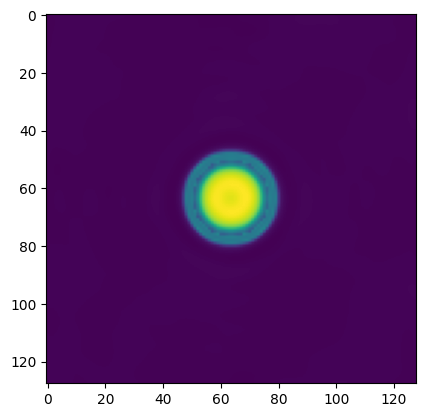

In [13]:
plt.imshow(rec_sample)

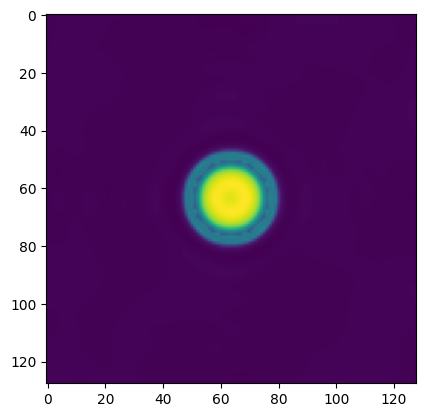

In [14]:
plt.imshow(sample)

In [25]:
x, y = sample_signal(test_func, scale)

In [45]:
coeffs = pywt.dwt(y, 'db6')
cA, cD = coeffs # cA coefficients (approximation) are for scaling (phi); cD (details) for wavelet (psi)
rec_sample = pywt.idwt(cA, cD, 'db6')

In [50]:
[phi, psi, x] = pywt.Wavelet('db6').wavefun(level=8) # phi - scaling; psi - wavelet

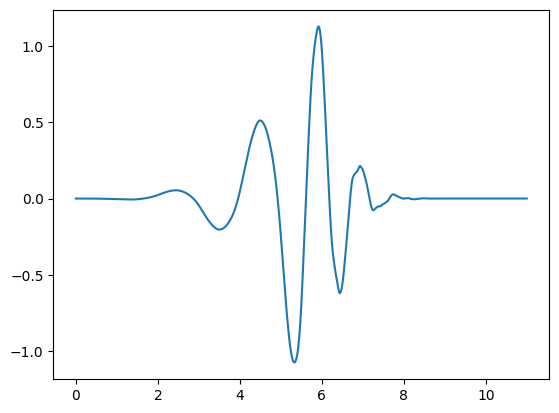

In [30]:
plt.plot(x, psi)

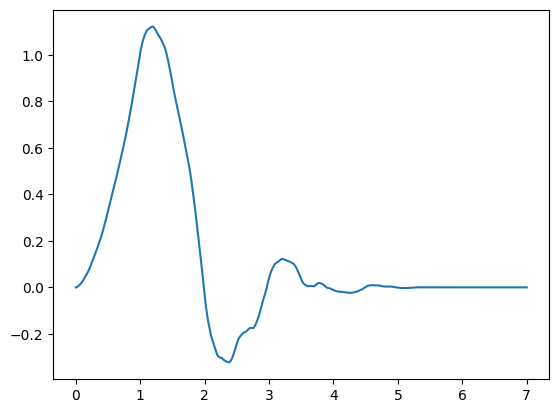

In [87]:
plt.plot(x, phi)
plt.show()

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import pywt
import math

In [2]:
def test_func(x):
    k1 = 5
    k2 = 20
    k = k1 + (k2 - k1) * (4 * (x-0.5)**3 + 0.5)
    return np.sin(k * x)


In [3]:
def sample_signal(test_f, scale):
    dx = pow(2, -scale)
    x = np.arange(0, 1, dx)
    y = np.array([test_f(x[i]) for i in range(x.shape[0])])
    y = test_f(x)
    return x, y

In [4]:
# Generate discrete signal
scale = 7
x, y = sample_signal(test_func, scale)
    
# Wavelet decomposition
wavelet = pywt.Wavelet('db2')
# coeffs = pywt.wavedec(y, wavelet)
coeffs = pywt.dwt(y, 'db2')
L, H = coeffs
nb_levels = len(coeffs) - 1
    
# Upsample wavelet function + linear interpolation
fL, fH, x_wav = wavelet.wavefun(level=scale+2)

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    return idx
        
# Reconstruct
k_s = 1. / sqrt(pow(2, scale))
x_rec = x #np.arange(0, 1, dx)
y_rec = np.zeros(y.shape)
# Fixing parameters
A = 0.0105              # <<<<<<<<<<<< db2: ~0.0105
B = wavelet.rec_len - 2 # <<<<<<<<<<<<

for i in range(x_rec.shape[0]):
    xi = x_rec[i] - A #pow(2, -scale)
    val = 0.

    # Approx
    inv_s = pow(2, scale - nb_levels)
    disc_fL = np.zeros(L.shape)
    for k in range(L.shape[0]):
        disc_fL[k] = k_s * sqrt(inv_s) * fL[find_nearest(x_wav, inv_s * xi - k + B)]

    # Details
    inv_s = pow(2, scale + 1 - nb_levels)
    disc_fH = np.zeros(H.shape)
    for k in range(H.shape[0]):
        disc_fH[k] = k_s * sqrt(inv_s) * fH[find_nearest(x_wav, inv_s * xi - k + B)]
    y_rec[i] = L @ disc_fL + H @ disc_fH

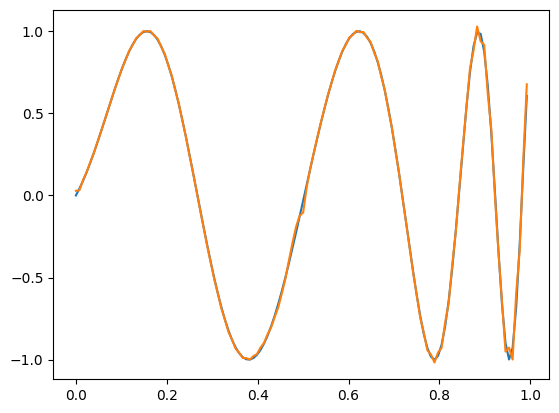

In [5]:
plt.plot(x, y)
plt.plot(x, y_rec)